In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")

Lagrange (generic function with 1 method)

In [2]:
function Rk2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0

    for i in 1:N
       k1= h*f(t[i], y[i])
       k2= h*f(t[i]+h, y[i]+k1)
       y[i+1]= y[i] + 0.5*(k1+k2) 
    end

    return t, y
end

Rk2 (generic function with 1 method)

convergence order = 2.0016152040012383


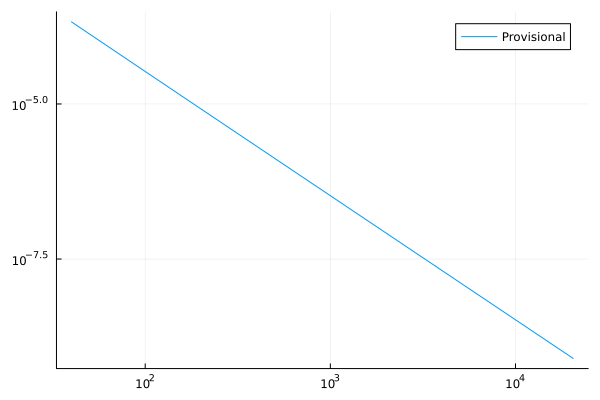

In [52]:
y0 = 1.0
lambda=-1
tspan=[0 1.0]
K = 10
err = zeros(K, 1)
ns=zeros(K, 1)
for k in 1:K
    N = 20* 2^k
    ns[k]=N
    h = (tspan[2] - tspan[1]) / N
    #f(t, y) = lambda * y
    f(t,y)= t .* y.^2 .* cos.(t) .^2
    (t, y) = Rk2(f, tspan, y0, N)
    # exact = y0 * exp.(lambda * t)
    exact=-8 ./(-9 .+ 2* t.^2 .+ cos.(2*t) .+ 2* t .* sin.(2*t)) 
    
    # Storing errors
    for i in 1:K+1
        err[k] = norm(exact[N+1] .- y[N+1])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Provisional")
display(plot!(legend=:topright))

In [3]:
function ridc_Rk2(f, tspan, h, y0, N, K)
    y=zeros(1, N+1, K+1)
    t, y[1, :, 1] = Rk2(f, tspan, y0, N) # Storing the provisonal solution
    
   for k in 1:K
        y[1, 1, k+1]=y0
        nfval=f(t, y[1, :, k])
        
        # Using Trapezoidal RK2 method for the first corrector and second corrector
        # (2k+2) equi-spaced nodes are used where k is the iteration. 
        
        # First nth steps
        for n in 2:(2*k+1)
            
            Qdr=Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n]) # Quadrature
            k1= h*(f(t[n-1], y[1, n-1, k+1])- f(t[n-1], y[1, n-1, k]))
            k2= h*(f(t[n-1] + h, y[1, n-1, k+1] + k1 + Qdr) - f(t[n-1]+h, y[1, n, k])) 
            
            y[1, n, k+1]=y[1, n-1, k+1] + k1/2 + k2/2 + Qdr
        end
        
        for j in (2*k+2):(N+1)
            
            Qdr=Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j]) # Quadrature 
            k1= h*(f(t[j-1], y[1, j-1, k+1])- f(t[j-1], y[1, j-1, k]))
            k2= h*((f(t[j-1]+h, y[1, j-1, k+1]+ k1 + Qdr)) - f(t[j-1]+h, y[1, j, k]) )
        
            y[1, j, k+1]=y[1, j-1, k+1] +  k1/2 + k2/2 + Qdr
        end
    end
    return t,  y
end

ridc_Rk2 (generic function with 1 method)

convergence order = 2.017774199342444
convergence order = 4.024354201245474
convergence order = 5.844133998714785


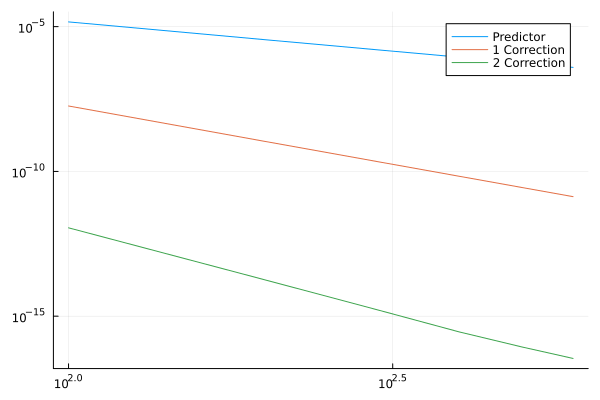

In [4]:
P = 6
y0 = 1.0
lambda=-1
tspan=[0 5]
K =2
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100* p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = lambda * y
    #f(t, y)= y .^2
    #f(t, y)= t .* y.^2 .* cos.(t) .^2
    (t, y) = ridc_Rk2(f, tspan, h, y0, N, K)
    
    exact = y0 * exp.(lambda * t)
    #exact= 1 ./(1 .- t)
    #exact=-8 ./(-9 .+ 2* t.^2 .+ cos.(2*t) .+ 2* t .* sin.(2*t)) 
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

convergence order = 1.8556844000577628
convergence order = 3.9332945963119013
convergence order = 5.82698266669658
convergence order = 6.515430346097084


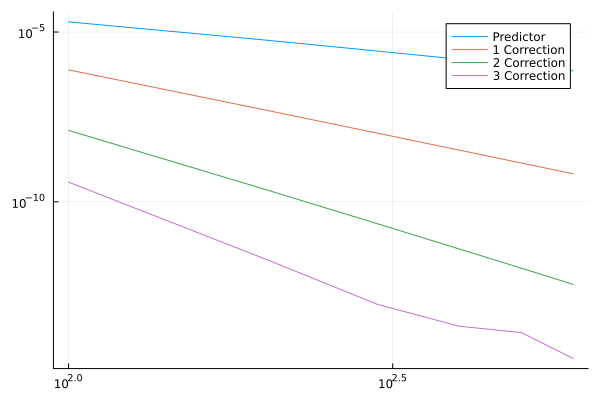

In [5]:
# Example 2: y'= t * y^2 * cos.(t)^2, y(0)=1; T in [0, 2]

using Plots
P = 6
y0 = 1.0

tspan=[0 2]
K = 3
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y)= t .* y.^2 .* cos.(t) .^2
   
    (t, y) = ridc_Rk2(f, tspan, h, y0, N, K)
    
    exact=-8 ./(-9 .+ 2* t.^2 .+ cos.(2*t) .+ 2* t .* sin.(2*t)) 
    
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

convergence order = 1.9929143354771828
convergence order = 3.962697144947441
convergence order = 5.874464404921518
convergence order = 3.961025599953901


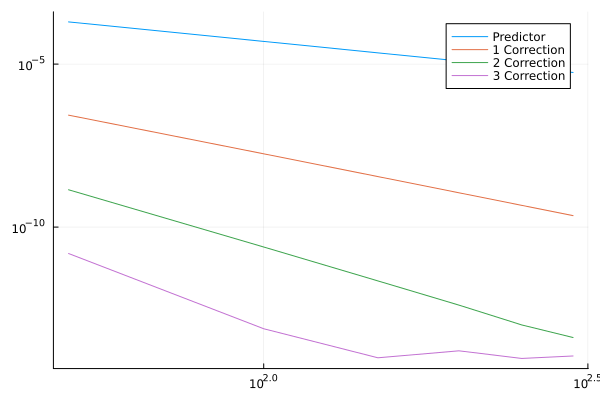

In [8]:
# Example 3: y'=  y^2 , y(0)=1; T in [0, 1/2]

using Plots
P = 6
y0 = 1.0

tspan=[0 1/2]
K = 3
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 50*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y)= y .^2
    (t, y) = ridc_Rk2(f, tspan, h, y0, N, K)
    exact= 1 ./ (1 .- t)
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

convergence order = 2.0002908472468093
convergence order = 4.020803090474916
convergence order = 6.020183432201324
convergence order = 4.194948503956244


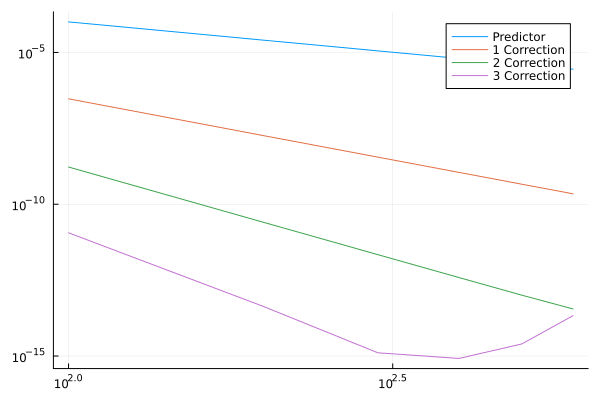

In [9]:
# Example 4: y'= - y .+ sin.(10*t) , y(0)=1; T in [0, 1]

using Plots
P = 6
y0 = 1.0

tspan=[0 1]
K = 3
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y)= - y .+ sin.(10*t)
    (t, y) = ridc_Rk2(f, tspan, h, y0, N, K)
    
    exact= -(1/101)* exp.(-t) .*(-111 .+10*exp.(t) .*cos.(10*t).- exp.(t) .*sin.(10*t))
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))